In [2]:
%load_ext autoreload
%autoreload 2

import pythainlp, transformers
pythainlp.__version__, transformers.__version__ #fix pythainlp to stabilize word tokenization for metrics

('2.2.4', '4.4.0')

In [3]:
import collections
import logging
import pprint
import re
from tqdm.auto import tqdm
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 800)

import torch

#datasets
from datasets import (
    load_dataset, 
    load_metric, 
    load_from_disk,
)

#transformers
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator,
)

#thai2transformers
import thai2transformers
from thai2transformers.metrics import (
    squad_newmm_metric,
    question_answering_metrics,
    _postprocess_qa_predictions
)
from thai2transformers.preprocess import (
    prepare_qa_train_features,
    prepare_qa_validation_features,
)

#parameterizing columns
CONTEXT_COL = 'context'
QUESTION_COL = 'question'
ANSWERS_COL = 'answers'
TEXT_COL = 'text'
START_COL = 'answer_start'
END_COL = 'answer_end'
QUESTION_ID_COL = 'question_id'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # Remove the CWD from sys.path while we load stuff.


## Datasets

In [4]:
datasets_cased = load_from_disk('iapp_thaiqa')

#lowercase when using uncased model
def lowercase_example(example):
    example[QUESTION_COL] =  example[QUESTION_COL].lower()
    example[CONTEXT_COL] =  example[CONTEXT_COL].lower()
    example[ANSWERS_COL][TEXT_COL] =  [example[ANSWERS_COL][TEXT_COL][0].lower()]
    return example

datasets_uncased = datasets_cased.map(lowercase_example)

Loading cached processed dataset at iapp_thaiqa/train/cache-ffa098ec2666f141.arrow
Loading cached processed dataset at iapp_thaiqa/validation/cache-8c23515661e2ced7.arrow
Loading cached processed dataset at iapp_thaiqa/test/cache-1466b900c9be98ee.arrow


## Models

In [5]:
#wangchan
tokenizer_wangchan = AutoTokenizer.from_pretrained("cstorm125/wangchanberta-base-att-spm-uncased-finetune-qa")
model_wangchan = AutoModelForQuestionAnswering.from_pretrained("cstorm125/wangchanberta-base-att-spm-uncased-finetune-qa")

#wanchan-wiki
tokenizer_wcwiki = AutoTokenizer.from_pretrained("cstorm125/wangchanberta-base-wiki-20210520-spm-finetune-qa")
model_wcwiki = AutoModelForQuestionAnswering.from_pretrained("cstorm125/wangchanberta-base-wiki-20210520-spm-finetune-qa")

#mbert
tokenizer_mbert = AutoTokenizer.from_pretrained("cstorm125/bert-base-multilingual-cased-finetune-qa")
model_mbert = AutoModelForQuestionAnswering.from_pretrained("cstorm125/bert-base-multilingual-cased-finetune-qa")

#xlm
tokenizer_xlm = AutoTokenizer.from_pretrained("cstorm125/xlm-roberta-base-finetune-qa")
model_xlm = AutoModelForQuestionAnswering.from_pretrained("cstorm125/xlm-roberta-base-finetune-qa")

## Compare Final Results

In [6]:
from pythainlp.tokenize import word_tokenize, syllable_tokenize
def character_tokenize(word): return [i for i in word]

def compare_final_results(tokenizer, 
                          model, 
                          datasets,
                          tok_func=word_tokenize,
                          n_best_size=20,
                          max_answer_length=100,
                          allow_no_answer=False,
                          max_length=416,):
    
    test_features = datasets.map(
        lambda x: prepare_qa_validation_features(x, tokenizer),
        batched=True,
        remove_columns=datasets.column_names
    )
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
    )
    
    metrics, formatted_predictions, references = question_answering_metrics(datasets = datasets,
                                                                            trainer=trainer,
                                                                            metric=squad_newmm_metric,
                                                                            tok_func=tok_func,
                                                                            n_best_size=n_best_size,
                                                                            max_answer_length=max_answer_length,
                                                                            allow_no_answer=allow_no_answer,
                                                                            question_col='question',
                                                                            context_col='context',
                                                                            question_id_col='question_id',
                                                                            answers_col='answers',
                                                                            text_col='text',
                                                                            start_col='answer_start',
                                                                            pad_on_right=True,
                                                                            max_length=max_length,
                                                                            doc_stride=128)

    pred = pd.DataFrame(formatted_predictions)
    ref = pd.DataFrame(references)
    ref['answer_text'] = ref.answers.map(lambda x: x['text'][0])
    question_df = pd.DataFrame(datasets)[['question_id','context','question']]
    question_df.columns = ['id','context','question']

    compare = ref[['id','answer_text']].merge(pred).merge(question_df)
    compare['exact_match'] = compare.answer_text==compare.prediction_text
    compare['f1'] = [squad_newmm_metric.compute(predictions=[p],references=[r])['f1'] for p,r in zip(formatted_predictions, references)]
    compare['partial_ratio'] = compare.apply(lambda row: fuzz.partial_ratio(str(row['answer_text']),
                                                                            str(row['prediction_text'])),1)

    # compare.sort_values('f1')[['question','answer_text','prediction_text','f1']]
    return compare, metrics

In [12]:
df_wangchan, metrics_wangchan = compare_final_results(tokenizer_wangchan, 
                                      model_wangchan, 
                                      datasets_uncased['test'], 
                                      tok_func=word_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=416,)

df_wcwiki, metrics_wcwiki = compare_final_results(tokenizer_wcwiki, 
                                      model_wcwiki, 
                                      datasets_cased['test'], 
                                      tok_func=word_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=400,)

df_xlm, metrics_xlm = compare_final_results(tokenizer_xlm, 
                                      model_xlm, 
                                      datasets_cased['test'], 
                                      tok_func=word_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

df_mbert, metrics_mbert = compare_final_results(tokenizer_mbert, 
                                      model_mbert, 
                                      datasets_cased['test'], 
                                      tok_func=word_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

Loading cached processed dataset at iapp_thaiqa/test/cache-3536c2cdfb6da01d.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-a3f38ec505e52afd.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-34596a785f80a720.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-1f5464554ef516eb.arrow


### Metrics

The gap most likely comes from the 7% difference in exact matches.

In [13]:
#final metrics; our exact match has a problem
metrics_wangchan, metrics_wcwiki, metrics_xlm, metrics_mbert

({'exact_match': 48.57916102841678, 'f1': 73.72159565026034},
 {'exact_match': 48.9851150202977, 'f1': 77.23698293985632},
 {'exact_match': 54.66847090663058, 'f1': 79.35555876284236},
 {'exact_match': 51.42083897158322, 'f1': 75.79187183319615})

### Deep Dive `wangchanberta` vs `xlmr`

In [14]:
a = df_wangchan[['id','question','answer_text','prediction_text','f1','partial_ratio']]
a.columns = ['id','question','answer_text','prediction_text_wangchan','f1_wangchan','partial_ratio_wangchan']
b = df_xlm[['id','question','answer_text','prediction_text','f1','partial_ratio']]
b.columns = ['id','question','answer_text','prediction_text_xlm','f1_xlm','partial_ratio_xlm']

ab = a.merge(b, on=['id','question','answer_text'])
ab.head()

,id,question,answer_text,prediction_text_wangchan,f1_wangchan,partial_ratio_wangchan,prediction_text_xlm,f1_xlm,partial_ratio_xlm
0,0fI5AjC5sb4CrqcHDvrX_000,อันดับย่อยปลานกขุนทอง เป็นอันดับย่อยของปลาอะไร,ปลาทะเลกระดูกแข็ง,ปลาทะเลกระดูกแข็ง,100.0,100,ปลาทะเลกระดูกแข็ง,100.000000,100
1,0fI5AjC5sb4CrqcHDvrX_001,อันดับย่อยปลานกขุนทอง อยู่ในอันดับอะไร,อันดับปลากะพง,อันดับปลากะพง,100.0,100,อันดับปลากะพง (Perciformes),60.000000,100
2,0fI5AjC5sb4CrqcHDvrX_002,อันดับย่อยปลานกขุนทอง มีริมฝีปากอย่างไร,ริมฝีปากหนา,ริมฝีปากหนา,100.0,100,ริมฝีปากหนา,100.000000,100
3,1pHZpClsr7QtLpXE7OsW_001,ปิติพงษ์ กุลดิลก เคยทำอาชีพอะไรมาก่อน,นักกีฬาฟุตบอล,เป็นนักกีฬาฟุตบอลทีมชาติไทย,50.0,100,นักกีฬาฟุตบอลทีมชาติไทย รวมถึงเคยทำหน้าที่เป็นนักฟุตบอลอาชีพ,28.571429,100
4,2AQthY1qATWu7AJozsbR_000,คลีโอพัตราที่ 6 ทรีฟาเอนา เป็นสมเด็จพระราชินี แห่งอาณาจักรใด,อาณาจักรอียิปต์โบราณ,อาณาจักรอียิปต์โบราณ,100.0,100,อาณาจักรอียิปต์โบราณ,100.000000,100


#### Distribution of F1

Confirms our hypothesis that difference lies in exact matches. Furthermore, those mistakes mostly come from totally wrong answers (`f1`=0) and mostly wrong answers (`f1`<50).

* yellow = `wangchan`
* blue = `xlmr`

<AxesSubplot:>

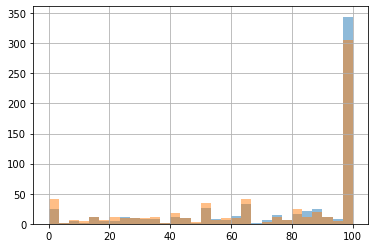

In [15]:
ab.f1_xlm.hist(bins=30, alpha=0.5)
ab.f1_wangchan.hist(bins=30, alpha=0.5)

<AxesSubplot:>

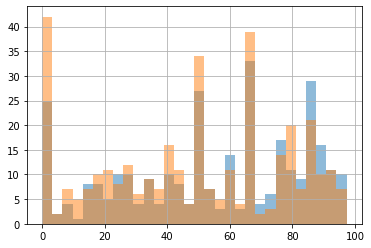

In [16]:
#plot only non-exact matches
ab[ab.f1_xlm<100].f1_xlm.hist(bins=30, alpha=0.5)
ab[ab.f1_wangchan<100].f1_wangchan.hist(bins=30, alpha=0.5)

In [17]:
#difference in exact matches
(ab.f1_xlm==100).sum() - (ab.f1_wangchan==100).sum(), ((ab.f1_xlm==100).sum() - (ab.f1_wangchan==100).sum()) / ab.shape[0]

(40, 0.06116207951070336)

In [18]:
#difference in f1 = 0
(ab.f1_wangchan==0).sum() - (ab.f1_xlm==0).sum(), ((ab.f1_wangchan==0).sum() - (ab.f1_xlm==0).sum()) / ab.shape[0]

(18, 0.027522935779816515)

In [19]:
#difference in f1 < 50
(ab.f1_wangchan<50).sum() - (ab.f1_xlm<50).sum(), ((ab.f1_wangchan<50).sum() - (ab.f1_xlm<50).sum()) / ab.shape[0]

(45, 0.06880733944954129)

#### Token-level F1 vs Fuzziness

Similar patterns suggest we might have same relative performance despite token-level (word, syllable, character) but we will try anyways.

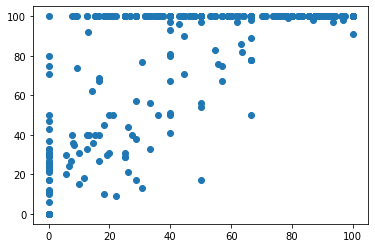

In [20]:
plt.scatter(df_wangchan.f1, df_wangchan.partial_ratio)

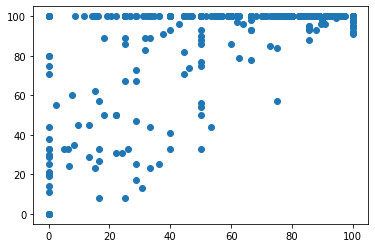

In [21]:
plt.scatter(df_xlm.f1, df_xlm.partial_ratio)

#### Contexts with sub-50 F1

In [22]:
wangchan_low =  df_wangchan[df_wangchan.f1<50].context.map(lambda x: x[:50]).value_counts().reset_index()
wangchan_low = wangchan_low[wangchan_low.context>1].reset_index(drop=True)
wangchan_low

,index,context
0,แอนนาเบลล์ (อังกฤษ: annabelle) เป็นตุ๊กตาผ้ารูปเรก,5
1,องค์การสุรา กรมสรรพสามิต (อังกฤษ: the liquor disti,4
2,พังโคน เป็นอำเภอที่ตั้งอยู่เกือบกึ่งกลางจังหวัดสกล,4
3,เบอร์เซิร์ก (ญี่ปุ่น: ベルセルク โรมาจิ: beruseruku; อั,4
4,ก้าวสู่ฝันวันหัวใจพบรัก (อังกฤษ: a walk to remembe,4
5,กร คุณาธิปอภิสิริ ชื่อเล่น อู๋จุน เกิดวันที่ 13 พฤ,3
6,จังหวัด เป็นเขตบริหารราชการส่วนภูมิภาคของประเทศไทย,3
7,พังก์ร็อก (อังกฤษ: punk rock) เป็นดนตรีร็อกประเภทห,3
8,การยุบสภาผู้แทนราษฎรไทย คือ การทำให้ความเป็นสมาชิก,3
9,พระพุทธมณีรัตนปฏิมากร เป็นพระพุทธรูปที่สร้างขึ้นใน,3


In [23]:
xlm_low =  df_xlm[df_xlm.f1<50].context.map(lambda x: x[:50]).value_counts().reset_index()
xlm_low = xlm_low[xlm_low.context>1].reset_index(drop=True)
xlm_low

,index,context
0,หนึ่ง-เก้า-แปด-สี่ (อังกฤษ: Nineteen Eighty-Four),5
1,วิวัฒน์ มิลินทจินดา (พ.ศ. 2466 – พ.ศ. 2546) เป็นนั,4
2,เส้นทางสายไหม (อังกฤษ: Silk Road หรือ Silk Route),3
3,องค์การสุรา กรมสรรพสามิต (อังกฤษ: The Liquor Disti,3
4,เบอร์เซิร์ก (ญี่ปุ่น: ベルセルク โรมาจิ: Beruseruku; อั,3
5,การยุบสภาผู้แทนราษฎรไทย คือ การทำให้ความเป็นสมาชิก,2
6,จังหวัด เป็นเขตบริหารราชการส่วนภูมิภาคของประเทศไทย,2
7,พังโคน เป็นอำเภอที่ตั้งอยู่เกือบกึ่งกลางจังหวัดสกล,2
8,องค์การบริหารส่วนตำบลกุดเพียขอม เป็นองค์กรปกครองส่,2
9,ปลาใบขนุน หรือที่นิยมเรียกและรู้จักกันในชื่อภาษาแต,2


We can confirm this is not because of translation since `wangchanberta` also underperforms in Thai-only contexts.

In [24]:
#top wangchan misses vs xlm gets it
wx = wangchan_low.merge(xlm_low, how='left', on='index')
wx[wx.context_y.isna()]

,index,context_x,context_y
0,แอนนาเบลล์ (อังกฤษ: annabelle) เป็นตุ๊กตาผ้ารูปเรก,5,NaN
1,องค์การสุรา กรมสรรพสามิต (อังกฤษ: the liquor disti,4,NaN
3,เบอร์เซิร์ก (ญี่ปุ่น: ベルセルク โรมาจิ: beruseruku; อั,4,NaN
4,ก้าวสู่ฝันวันหัวใจพบรัก (อังกฤษ: a walk to remembe,4,NaN
5,กร คุณาธิปอภิสิริ ชื่อเล่น อู๋จุน เกิดวันที่ 13 พฤ,3,NaN
7,พังก์ร็อก (อังกฤษ: punk rock) เป็นดนตรีร็อกประเภทห,3,NaN
9,พระพุทธมณีรัตนปฏิมากร เป็นพระพุทธรูปที่สร้างขึ้นใน,3,NaN
10,แม่มด หมายถึง หมอเวทมนตร์หรือหมอผี ถ้าเป็นชายเรียก,3,NaN
13,เส้นทางสายไหม (อังกฤษ: silk road หรือ silk route),3,NaN
15,หนึ่ง-เก้า-แปด-สี่ (อังกฤษ: nineteen eighty-four),3,NaN


In [25]:
#top xlm misses vs wangchan gets it; significantly fewer
xw = xlm_low.merge(wangchan_low, how='left', on='index')
xw[xw.context_y.isna()]

,index,context_x,context_y
0,หนึ่ง-เก้า-แปด-สี่ (อังกฤษ: Nineteen Eighty-Four),5,NaN
2,เส้นทางสายไหม (อังกฤษ: Silk Road หรือ Silk Route),3,NaN
3,องค์การสุรา กรมสรรพสามิต (อังกฤษ: The Liquor Disti,3,NaN
4,เบอร์เซิร์ก (ญี่ปุ่น: ベルセルク โรมาจิ: Beruseruku; อั,3,NaN
8,องค์การบริหารส่วนตำบลกุดเพียขอม เป็นองค์กรปกครองส่,2,NaN
10,อาเดรียน ซาน มิเกล เดล กัสติโย (สเปน: Adrián San M,2,NaN
11,พื่อน..ที่ระลึก (อังกฤษ: The Promise) เป็นภาพยนตร์,2,NaN
12,ภาพยนตร์ชุด วิ่งสู้ฟัด (อังกฤษ: Police Story Film,2,NaN
13,ในนาซีเยอรมนีสามเหลี่ยมชมพู (เยอรมัน: Rosa Winkel),2,NaN
16,"ชาวเบงกอล (เบงกอล: বাঙালি; อังกฤษ: Bengali, Bangal",2,NaN


### `xlmr` Exact Matches vs `wangchanberta` Non-Exact Matches

There seems to be a problem in word tokenization.

In [26]:
from pythainlp.tokenize import word_tokenize
word_tokenize('ภาษามลายู'), word_tokenize('มลายู')

(['ภาษามลายู'], ['มลายู'])

In [27]:
xlm_better_wangchan = ab[(ab.f1_xlm==100)&(ab.f1_wangchan<100)]
xlm_better_wangchan.sort_values('f1_wangchan')

,id,question,answer_text,prediction_text_wangchan,f1_wangchan,partial_ratio_wangchan,prediction_text_xlm,f1_xlm,partial_ratio_xlm
322,VZPy4H0eKhN3Esb6xuX1_002,อาชีพของกร คุณาธิปอภิสิริคืออะไร,นักแสดงและนายแบบชาวไทย,ธุรกิจส่วนตัว,0.000000,23,นักแสดงและนายแบบชาวไทย,100.0,100
374,XlXpU8w6aUcV1Y7M6VrR_003,เอ็ดเวิร์ด มโพฟู ได้แชมครั้งแรกที่ไหน,แอฟริกาใต้,29 มีนาคม พ.ศ. 2541,0.000000,10,แอฟริกาใต้,100.0,100
456,fA2RsLy7G6aQ8TBWOZNb_000,ยูโรปา ยูนิเวอร์ซาลิส 3คืออะไร,วีดีโอเกมแนววางแผนการรบแบบเรียลไทม์ที่เน้นยุทธศาสตร์ระดับประเทศ,เอนจิน 3d,0.000000,22,วีดีโอเกมแนววางแผนการรบแบบเรียลไทม์ที่เน้นยุทธศาสตร์ระดับประเทศ,100.0,100
313,Ty522S3gcyoVn1u7VuOS_003,สงครามบอลข่านครั้งที่หนึ่งสู้รบกันระหว่างสันนิบาตบอลข่านและจักรวรรดิออตโตมัน เกิดขึ้นระหว่าง ค.ศ. ใด,ค.ศ. 1912 และ 1913,1914,0.000000,75,ค.ศ. 1912 และ 1913,100.0,100
275,QxPN76A8pL3IF06djvNj_003,เหตุผลในการยุบสภาผู้แทนราษฎรไทย คืออะไร,หาได้มีบทบัญญัติแห่งกฎหมายใดบัญญัติไว้ไม่,การทำให้ความเป็นสมาชิกภาพของสมาชิกสภาผู้แทนราษฎรไทยสิ้นสุดลง,0.000000,22,หาได้มีบทบัญญัติแห่งกฎหมายใดบัญญัติไว้ไม่,100.0,100
481,j5jDkthGOw9bJSjX1pBR_001,ภายใต้ธรรมนูญการปกครองตนเองแห่งแคว้นบาเลนเซียใครได้รับการจัดตั้งขึ้นเพื่อให้เป็นผู้วางระเบียบเกี่ยวการใช้ภาษา,บัณฑิตยสถานภาษาแห่งบาเลนเซีย,จูอาน็อต มาร์โตเร็ลย์,0.000000,29,บัณฑิตยสถานภาษาแห่งบาเลนเซีย,100.0,100
182,IDlHiLyTsWSbfCR4spll_004,ชดช้อยเป็นฝ่ายชนะน็อคในยกที่ 3 จนทำให้ใครถูกปลดจากแชมป์โลก,โนรี,26 กุมภาพันธ์ พ.ศ. 2543,0.000000,25,โนรี,100.0,100
515,lTcJq7fmi90zcPxuvvRW_002,ยุทธการใต้สมุทร เป็นผลงานโดยใคร,ไคจิ คาวางูจิ,สำนักพิมพ์วิบูลย์กิจ,0.000000,31,ไคจิ คาวางูจิ,100.0,100
110,BVccu2vbXhlKavM15M2p_002,โอลิวีน มีอีกความหมายว่าอะไร,แร่ประกอบหิน,สีเขียวมะกอก (olive green),0.000000,25,แร่ประกอบหิน,100.0,100
542,mIEUhmVfrZlOz9y3WMaY_004,เอ็ด และลอร์เรน วอร์เรนคือใคร,คู่สามีภรรยาซึ่งเป็นนักปิศาจวิทยาและนักสืบสวนสอบสวนเรื่องลึกลับเหนือธรรมชาติที่มีชื่อเสียง,ตุ๊กตาผ้ารูปเรกกาดี แอนน์,0.000000,24,คู่สามีภรรยาซึ่งเป็นนักปิศาจวิทยาและนักสืบสวนสอบสวนเรื่องลึกลับเหนือธรรมชาติที่มีชื่อเสียง,100.0,100


#### Syllable and Character Levels

`wangchanberta` consistently underperforms in word, syllable and character tokenizations.

In [38]:
df_wangchan_syllable, metrics_wangchan_syllable = compare_final_results(tokenizer_wangchan, 
                                      model_wangchan, 
                                      datasets_uncased['test'], 
                                      tok_func=syllable_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=416,)

df_wcwiki_syllable, metrics_wcwiki_syllable = compare_final_results(tokenizer_wcwiki, 
                                      model_wcwiki, 
                                      datasets_cased['test'], 
                                      tok_func=syllable_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=400,)

df_xlm_syllable, metrics_xlm_syllable = compare_final_results(tokenizer_xlm, 
                                      model_xlm, 
                                      datasets_cased['test'], 
                                      tok_func=syllable_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

df_mbert_syllable, metrics_mbert_syllable = compare_final_results(tokenizer_mbert, 
                                      model_mbert, 
                                      datasets_cased['test'], 
                                      tok_func=syllable_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

Loading cached processed dataset at iapp_thaiqa/test/cache-3536c2cdfb6da01d.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-a3f38ec505e52afd.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-34596a785f80a720.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-1f5464554ef516eb.arrow


In [39]:
df_wangchan_character, metrics_wangchan_character = compare_final_results(tokenizer_wangchan, 
                                      model_wangchan, 
                                      datasets_uncased['test'], 
                                      tok_func=character_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=416,)

df_wcwiki_character, metrics_wcwiki_character = compare_final_results(tokenizer_wcwiki, 
                                      model_wcwiki, 
                                      datasets_cased['test'], 
                                      tok_func=character_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=400,)

df_xlm_character, metrics_xlm_character = compare_final_results(tokenizer_xlm, 
                                      model_xlm, 
                                      datasets_cased['test'], 
                                      tok_func=character_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

df_mbert_character, metrics_mbert_character = compare_final_results(tokenizer_mbert, 
                                      model_mbert, 
                                      datasets_cased['test'], 
                                      tok_func=character_tokenize,
                                      n_best_size=20,
                                      max_answer_length=100,
                                      allow_no_answer=False,
                                      max_length=512,)

Loading cached processed dataset at iapp_thaiqa/test/cache-3536c2cdfb6da01d.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-a3f38ec505e52afd.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-34596a785f80a720.arrow


Loading cached processed dataset at iapp_thaiqa/test/cache-1f5464554ef516eb.arrow


In [40]:
metrics_wangchan, metrics_wcwiki, metrics_xlm, metrics_mbert

({'exact_match': 48.57916102841678, 'f1': 73.72159565026034},
 {'exact_match': 48.9851150202977, 'f1': 77.23698293985632},
 {'exact_match': 54.66847090663058, 'f1': 79.35555876284236},
 {'exact_match': 51.42083897158322, 'f1': 75.79187183319615})

In [41]:
metrics_wangchan_syllable, metrics_wcwiki_syllable, metrics_xlm_syllable, metrics_mbert_syllable

({'exact_match': 48.57916102841678, 'f1': 75.26453989608667},
 {'exact_match': 48.9851150202977, 'f1': 78.99155092444835},
 {'exact_match': 54.66847090663058, 'f1': 81.15183608864342},
 {'exact_match': 51.42083897158322, 'f1': 77.3011529514406})

In [42]:
metrics_wangchan_character, metrics_wcwiki_character, metrics_xlm_character, metrics_mbert_character

({'exact_match': 48.57916102841678, 'f1': 77.6488627139421},
 {'exact_match': 48.9851150202977, 'f1': 81.34355905127896},
 {'exact_match': 54.66847090663058, 'f1': 82.81788338530721},
 {'exact_match': 51.42083897158322, 'f1': 79.45429201568685})

## `wangchanberta` Trained Only on Wikipedia

Domain mismatch can be one of the key reasons `wangchanberta` underperforms multilingual models. This seems to be the cased as shown in [experiment results](https://wandb.ai/cstorm125/wangchanberta-qa?workspace=user-cstorm125)